# GDR RSD School - Hackathon - Locust load injection

This notebook presents how to use the Locust to inject the load in the system.

Locust runs N clients performing CoAP requests to the sensors.

Each client generates a load of **1 request per second to some sensor (randomly chosen)**.

Main parameters:

    - users: number of clients generating CoAP requests to sensors
    - duration: total time that clients are running, or duration of the load injection.

## Parameters of this notebook

In [1]:
%cd ../../
%pwd

/home/jovyan/work


'/home/jovyan/work'

In [2]:
import enoslib as en

import logging
import sys
import datetime
import pathlib
import uuid

The Vagrant executable cannot be found. Please check if it is in the system path.


Note: Openstack clients not installed


---
This cell presents all the paramters used in this notebook that can be modified through papermill.

**Important**: set the site (*iotlab_site*) and IPv6 network (*iotlab_ipv6_net*) assigned to you in [rsd2021hack.csv](../../setup/rsd2021hack.csv)

In [3]:
#parameters to this notebook
output_dir = "data/raw/%s/%s" % (str(datetime.date.today()), str(uuid.uuid4())) # location for output files
br_image="data/firmware/custom/contikimac/border-router.iotlab-m3"      # border router firmware
er_image="data/firmware/custom/contikimac/er-example-server.iotlab-m3"  # sensor/coap server firmware
iotlab_site="grenoble" # IoT-LAB site
iotlab_nodes=4         # number of nodes in IoT-LAB platform, 1 border router, N - 1 sensors
iotlab_ipv6_net="2001:660:5307:3142::"  # IPv6 subnet, depends on the site
job_name="hackathon"   # job_name to submit to platforms
duration=10           # duration of load injection
users=1               # number of clients doing requests for CoAP servers
free_resources = True  # destroy job in testbeds at the end
g5k_nodes=1

In [4]:
# Parameters
output_dir = "data/raw/2021-09-29/d0b20657-c154-46fa-884a-f45cea57bdfb"
er_image = "data/firmware/custom/tsch/er-example-server.iotlab-m3"
br_image = "data/firmware/custom/tsch/border-router.iotlab-m3"
free_resources = False
duration = 300
users = 20
iotlab_nodes = 4
iotlab_site = "grenoble"
g5k_nodes = 1


## Initialization

Some information about this experiment

In [5]:
# creating output folder
pathlib.Path(output_dir).mkdir(exist_ok=True, parents=True)
print("Starting new experiment %s" % (output_dir))

Starting new experiment data/raw/2021-09-29/d0b20657-c154-46fa-884a-f45cea57bdfb


Configuring logging: save DEBUG to a file and INFO to stdout

In [6]:
log = logging.getLogger()
log.setLevel(logging.DEBUG)

formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fileHandler = logging.FileHandler("%s/debug.log" % (output_dir), 'a')
fileHandler.setLevel(logging.DEBUG)
fileHandler.setFormatter(formatter)
log.addHandler(fileHandler)

cformat = logging.Formatter("[%(levelname)8s] : %(message)s")
consoleHandler = logging.StreamHandler(sys.stdout)
consoleHandler.setFormatter(cformat)
consoleHandler.setLevel(logging.INFO)
log.addHandler(consoleHandler)

## IoT-LAB resources

### Describing the resources

Get list of IoT-LAB nodes available

In [7]:
import os

iotlab_nodes_list = []

with open(os.path.expanduser("~/.iotlab_nodes"), "r") as f:
    iotlab_nodes_list = f.read().splitlines()

print("Available nodes: %s" % str(iotlab_nodes_list))
br_nodes = iotlab_nodes_list[0:1] # 1 border router
coap_nodes = iotlab_nodes_list[1:iotlab_nodes] # n - 1 CoAP servers

print("Border-router: %s" % str(br_nodes))
print("CoAP servers: %s" % str(coap_nodes))

Available nodes: ['m3-15.grenoble.iot-lab.info', 'm3-16.grenoble.iot-lab.info', 'm3-17.grenoble.iot-lab.info', 'm3-18.grenoble.iot-lab.info', 'm3-19.grenoble.iot-lab.info']
Border-router: ['m3-15.grenoble.iot-lab.info']
CoAP servers: ['m3-16.grenoble.iot-lab.info', 'm3-17.grenoble.iot-lab.info', 'm3-18.grenoble.iot-lab.info']


Describing resources usinb EnOSlib.

In [8]:
iotlab_dict = {
    "job_name": job_name,
    "walltime": "02:00",       # duration of the experiment: e.g. 1 hour
    "resources":
    {"machines": [
        {
            "roles": ["coap-server"],      # user-defined role for these nodes: CoAP servers
            "hostname": coap_nodes,            
            "image": er_image,             # initial image to be installed on the nodes
            "profile": "energy",           # monitoring profile, defined below
        },
        {
            "roles": ["border-router"],   # user-defined string, 1 border-router in our example
            "hostname": br_nodes,                        
            "image": br_image,
            "profile": "energy",
        },
    ]},
    "monitoring": {
        "profiles": [{
            "name": "energy",           # More details: https://www.iot-lab.info/legacy/tutorials/monitoring-consumption-m3/index.html
            "archi": "m3",
            "consumption": {
                "current": True,
                "power": True,
                "voltage": True,
                "period": 8244,         # interval between measurements in us
                "average": 4,
            },
        }]
    }
}

# creating the object for our reservation
# the nodes aren't avaible until you call init() on these objects
iotlab_conf = en.IotlabConf.from_dictionary(iotlab_dict)
iotlab_conf

Conf@0x7fbb981d00d0
{
    "job_name": "hackathon",
    "walltime": "02:00",
    "resources": {
        "machines": [
            {
                "roles": [
                    "coap-server"
                ],
                "image": "data/firmware/custom/tsch/er-example-server.iotlab-m3",
                "profile": "energy",
                "hostname": [
                    "m3-16.grenoble.iot-lab.info",
                    "m3-17.grenoble.iot-lab.info",
                    "m3-18.grenoble.iot-lab.info"
                ]
            },
            {
                "roles": [
                    "border-router"
                ],
                "image": "data/firmware/custom/tsch/border-router.iotlab-m3",
                "profile": "energy",
                "hostname": [
                    "m3-15.grenoble.iot-lab.info"
                ]
            }
        ],
        "networks": []
    },
    "monitoring": {
        "profiles": [
            {
                "name": "energy",
                "archi": "m3",
                "consumption": {
                    "current": true,
                    "power": true,
                    "voltage": true,
                    "period": 8244,
                    "average": 4
                }
            }
        ]
    }
}

### Reserving the resources

In [9]:
iotlab_provider = en.Iotlab(iotlab_conf)
iotlab_roles, iotlab_networks = iotlab_provider.init()
iotlab_roles

[    INFO] : Profile: energy, already exists. Skipping creation.


[    INFO] : Waiting for job id (279204) to be in running state


[    INFO] : Job id (279204) is running


[    INFO] : Finished reserving nodes: hosts [], sensors [<IotlabSensor(roles=['coap-server'], address=m3-16.grenoble.iot-lab.info, site=grenoble, uid=a269)>image=data/firmware/custom/tsch/er-example-server.iotlab-m3)>, <IotlabSensor(roles=['coap-server'], address=m3-17.grenoble.iot-lab.info, site=grenoble, uid=a172)>image=data/firmware/custom/tsch/er-example-server.iotlab-m3)>, <IotlabSensor(roles=['coap-server'], address=m3-18.grenoble.iot-lab.info, site=grenoble, uid=b679)>image=data/firmware/custom/tsch/er-example-server.iotlab-m3)>, <IotlabSensor(roles=['border-router'], address=m3-15.grenoble.iot-lab.info, site=grenoble, uid=c280)>image=data/firmware/custom/tsch/border-router.iotlab-m3)>]


[    INFO] : Flashing image (data/firmware/custom/tsch/er-example-server.iotlab-m3) on nodes (['m3-16.grenoble.iot-lab.info', 'm3-17.grenoble.iot-lab.info', 'm3-18.grenoble.iot-lab.info'])


[    INFO] : Flashing image (data/firmware/custom/tsch/border-router.iotlab-m3) on nodes (['m3-15.grenoble.iot-lab.info'])


{'coap-server': [<IotlabSensor(roles=['coap-server'], address=m3-16.grenoble.iot-lab.info, site=grenoble, uid=a269)>image=data/firmware/custom/tsch/er-example-server.iotlab-m3)>, <IotlabSensor(roles=['coap-server'], address=m3-17.grenoble.iot-lab.info, site=grenoble, uid=a172)>image=data/firmware/custom/tsch/er-example-server.iotlab-m3)>, <IotlabSensor(roles=['coap-server'], address=m3-18.grenoble.iot-lab.info, site=grenoble, uid=b679)>image=data/firmware/custom/tsch/er-example-server.iotlab-m3)>], 'border-router': [<IotlabSensor(roles=['border-router'], address=m3-15.grenoble.iot-lab.info, site=grenoble, uid=c280)>image=data/firmware/custom/tsch/border-router.iotlab-m3)>]}

### Setting up the IPv6 connectivity

Based on the tutorial: https://www.iot-lab.info/legacy/tutorials/contiki-coap-m3/index.html
More details in: https://www.iot-lab.info/legacy/tutorials/understand-ipv6-subnetting-on-the-fit-iot-lab-testbed/index.html

The procedure consists in:
1. getting an available IPv6 prefix from the testbed (Each group need to select a different network for communication)
2. running the `tunslip6` command on the frontend node: this daemon will connect your border router with the outside world.

So, first we check which prefix is taken from the list of the known routes on the frontend.

In [10]:
import iotlabcli.auth
iotlab_user, _ = iotlabcli.auth.get_user_credentials()   # get your credentials from .iotlabrc to connect to frontend node.

fit_frontend = en.Host("%s.iot-lab.info" % iotlab_site, alias=iotlab_site, user=iotlab_user) 

Reseting border router node and run the tunslip command

In [11]:
en.run('pgrep -u "$(whoami)" tunslip6 | xargs -r kill', fit_frontend)

iotlab_roles["border-router"][0].reset()

# run tunslip6 command in background
tun_cmd = "sudo tunslip6.py -v2 -L -a %s -p 20000 %s%d/64 > tunslip.output 2>&1" % (iotlab_roles["border-router"][0].alias, iotlab_ipv6_net, 1)
en.run_command(tun_cmd, roles=fit_frontend, background=True)

for sensor in iotlab_roles["coap-server"]:
    sensor.reset()

[WARNING]: No inventory was parsed, only implicit localhost is available



PLAY [all] *********************************************************************



TASK [pgrep -u "$(whoami)" tunslip6 | xargs -r kill] ***************************


 [started TASK: pgrep -u "$(whoami)" tunslip6 | xargs -r kill on grenoble]


changed: [grenoble]


[    INFO] : Executing command (reset) on nodes (['m3-15.grenoble.iot-lab.info'])



PLAY [all] *********************************************************************



TASK [sudo tunslip6.py -v2 -L -a m3-15 -p 20000 2001:660:5307:3142::1/64 > tunslip.output 2>&1] ***


 [started TASK: sudo tunslip6.py -v2 -L -a m3-15 -p 20000 2001:660:5307:3142::1/64 > tunslip.output 2>&1 on grenoble]


changed: [grenoble]


[    INFO] : Executing command (reset) on nodes (['m3-16.grenoble.iot-lab.info'])


[    INFO] : Executing command (reset) on nodes (['m3-17.grenoble.iot-lab.info'])


[    INFO] : Executing command (reset) on nodes (['m3-18.grenoble.iot-lab.info'])


Looking output of tunslip command to check status and get border router IPv6 address.

In [12]:
from retry import retry
import re
@retry(AttributeError, tries=5, delay=1, backoff=2)
def get_br_ipv6_address(frontend):
    results = en.run("cat tunslip.output", frontend)
    
    out = results[0].stdout
    # print(out)
    match = re.search(rf'Server IPv6 addresses:\n.+(2001[0-9a-fA-F:]+)\n', out, re.MULTILINE|re.DOTALL)
    return match.groups()[0]

br_ipv6 = get_br_ipv6_address(fit_frontend)
print("Border Router IPv6 address from tunslip output: %s" % br_ipv6)


PLAY [all] *********************************************************************



TASK [cat tunslip.output] ******************************************************


 [started TASK: cat tunslip.output on grenoble]


changed: [grenoble]


Border Router IPv6 address from tunslip output: 2001:660:5307:3142::c280


## Grid5000 resources

### Describing the resources

In [13]:
g5k_dict = {
    "job_type": "allow_classic_ssh",
    "job_name": job_name,
    "walltime": "02:00:00",
    "resources": {
        "machines": [
            {
                "roles": ["server"],
                "cluster": "paravance",
                "nodes": g5k_nodes,
                "primary_network": "default",
            },
        ],
        "networks": [
            {"id": "default", "type": "prod", "roles": ["prod"], "site": "rennes"}
        ],
    },
}
g5k_conf = en.G5kConf.from_dictionnary(g5k_dict)
g5k_conf

Conf@0x7fbb92924670
{
    "dhcp": true,
    "force_deploy": false,
    "env_name": "debian10-x64-nfs",
    "job_name": "hackathon",
    "job_type": [
        "allow_classic_ssh"
    ],
    "key": "/home/jovyan/.ssh/id_rsa.pub",
    "queue": "default",
    "walltime": "02:00:00",
    "resources": {
        "machines": [
            {
                "roles": [
                    "server"
                ],
                "primary_network": "default",
                "secondary_networks": [],
                "cluster": "paravance",
                "nodes": 1
            }
        ],
        "networks": [
            {
                "id": "default",
                "type": "prod",
                "roles": [
                    "prod"
                ],
                "site": "rennes"
            }
        ]
    }
}

### Reserving the resources

In [14]:
g5k_provider = en.G5k(g5k_conf)
g5k_roles, g5k_networks = g5k_provider.init()
g5k_roles

[    INFO] : Reloading hackathon from grenoble


[    INFO] : Reloading hackathon from lille


[    INFO] : Reloading hackathon from luxembourg


[    INFO] : Reloading hackathon from lyon


[    INFO] : Reloading hackathon from nancy


[    INFO] : Reloading hackathon from nantes


[    INFO] : Reloading hackathon from rennes


[    INFO] : Reloading 1820542 from rennes


[    INFO] : Reloading hackathon from sophia


[    INFO] : Waiting for 1820542 on rennes [2021-09-29 15:54:21]


[    INFO] : All jobs are Running !


{'server': [Host(address='paravance-8.rennes.grid5000.fr', alias='paravance-8.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set())]}

### Setting up the IPv6 connectivity

In [15]:
en.run("dhclient -6 br0", g5k_roles)
g5k_roles = en.sync_info(g5k_roles, g5k_networks) # get IPV6 addresses
g5k_roles


PLAY [all] *********************************************************************



TASK [dhclient -6 br0] *********************************************************


 [started TASK: dhclient -6 br0 on paravance-8.rennes.grid5000.fr]


changed: [paravance-8.rennes.grid5000.fr]



PLAY [all] *********************************************************************



TASK [hostname] ****************************************************************


 [started TASK: hostname on paravance-8.rennes.grid5000.fr]


changed: [paravance-8.rennes.grid5000.fr]



PLAY [Gather facts for all hosts] **********************************************



TASK [Gathering Facts] *********************************************************


ok: [paravance-8.rennes.grid5000.fr]



TASK [setup] *******************************************************************


ok: [paravance-8.rennes.grid5000.fr]



PLAY [Utils functions] *********************************************************



TASK [Gathering Facts] *********************************************************


ok: [paravance-8.rennes.grid5000.fr]



TASK [utils : include] *********************************************************


included: /opt/conda/lib/python3.9/site-packages/enoslib/ansible/roles/utils/tasks/check_network.yml for paravance-8.rennes.grid5000.fr



TASK [utils : Dump network information in a file] ******************************


changed: [paravance-8.rennes.grid5000.fr -> localhost]



TASK [utils : Create the fake interfaces] **************************************


skipping: [paravance-8.rennes.grid5000.fr]



PLAY RECAP *********************************************************************


paravance-8.rennes.grid5000.fr : ok=5    changed=1    unreachable=0    failed=0    skipped=1    rescued=0    ignored=0   


{'server': [Host(address='paravance-8.rennes.grid5000.fr', alias='paravance-8.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices={BridgeDevice(name='br0', addresses={IPAddress(network=<enoslib.infra.enos_g5k.objects.G5kEnosProd6Network object at 0x7fbb9291a340>, ip=IPv6Interface('2001:660:4406:700:1::8/128')), IPAddress(network=None, ip=IPv6Interface('fe80::eef4:bbff:fed1:180/64')), IPAddress(network=<enoslib.infra.enos_g5k.objects.G5kEnosProd4Network object at 0x7fbb981c1490>, ip=IPv4Interface('172.16.96.8/20'))}, bridged=['eno1']), NetDevice(name='eno4', addresses=set()), NetDevice(name='eno1', addresses=set()), NetDevice(name='eno2', addresses=set()), NetDevice(name='eno3', addresses=set()), NetDevice(name='lo', addresses={IPAddress(network=None, ip=IPv4Interface('127.0.0.1/8')), IPAddress(network=None, ip=IPv6Interface('::1/128'))})})]}

Install some packages

In [16]:
with en.play_on(pattern_hosts="server", roles=g5k_roles) as p:
    p.shell("pip3 install coapthon3")


PLAY [server] ******************************************************************



TASK [pip3 install coapthon3] **************************************************


 [started TASK: pip3 install coapthon3 on paravance-8.rennes.grid5000.fr]


changed: [paravance-8.rennes.grid5000.fr]


## Load injection with EnOSlib and Locust

EnOSlib exposes a service to stress a system: [The Locust service](https://discovery.gitlabpages.inria.fr/enoslib/apidoc/service.html#locust-load-generation).


[Locust](locust.io) is a load generation framework written with nice scalability garantees.


EnOSlib instantiates a Locust cluster on some target nodes and let you run your load generation and backup the resulting reports.

### First locust example


First Locust and its dependency is deployed on the G5k side

We use a single node in this tutorial which will serve as the master and worker node for our Locust cluster.

By default the `locustfile.py` located in the `local_expe_dir=src` is used. It's used by Locust to generate the simulated users stressing the system.

### Prerequisites

First, we need to get the IPv6 address of CoAP sensors.
For that, request it through Border Router's web interface,

In [17]:
@retry(AttributeError, tries=12, delay=1, backoff=2)
def get_sensor_ipv6_address(frontend):
    result = en.run('lynx --dump http://[%s]' % br_ipv6, [frontend])
    out = result[0].stdout
    print(out)
    node_uids = re.findall(r'(^2001[0-9a-fA-F:]+)', out, re.MULTILINE|re.DOTALL)
    node_uids = list(set(node_uids))
    if (len(node_uids) != iotlab_nodes - 1):
        raise AttributeError('Not enough sensors found')
    return node_uids

COAP_NODES = get_sensor_ipv6_address(fit_frontend)
print(COAP_NODES)


PLAY [all] *********************************************************************



TASK [lynx --dump http://[2001:660:5307:3142::c280]] ***************************


 [started TASK: lynx --dump http://[2001:660:5307:3142::c280] on grenoble]


changed: [grenoble]


   Neighbors
fe80::a172

   Routes

   Links
2001:660:5307:3142::a172 (parent: 2001:660:5307:3142::c280) 1778s
[ WARNING] : Not enough sensors found, retrying in 1 seconds...



PLAY [all] *********************************************************************



TASK [lynx --dump http://[2001:660:5307:3142::c280]] ***************************


 [started TASK: lynx --dump http://[2001:660:5307:3142::c280] on grenoble]


changed: [grenoble]


   Neighbors
fe80::a172

   Routes

   Links
2001:660:5307:3142::a172 (parent: 2001:660:5307:3142::c280) 1775s
[ WARNING] : Not enough sensors found, retrying in 2 seconds...



PLAY [all] *********************************************************************



TASK [lynx --dump http://[2001:660:5307:3142::c280]] ***************************


 [started TASK: lynx --dump http://[2001:660:5307:3142::c280] on grenoble]


changed: [grenoble]


   Neighbors
fe80::a172

   Routes

   Links
2001:660:5307:3142::a172 (parent: 2001:660:5307:3142::c280) 1771s
[ WARNING] : Not enough sensors found, retrying in 4 seconds...



PLAY [all] *********************************************************************



TASK [lynx --dump http://[2001:660:5307:3142::c280]] ***************************


 [started TASK: lynx --dump http://[2001:660:5307:3142::c280] on grenoble]


changed: [grenoble]


   Neighbors
fe80::a172
fe80::a269
fe80::b679

   Routes

   Links
2001:660:5307:3142::a172 (parent: 2001:660:5307:3142::c280) 1798s
2001:660:5307:3142::a269 (parent: 2001:660:5307:3142::c280) 1796s
2001:660:5307:3142::b679 (parent: 2001:660:5307:3142::c280) 1798s
['2001:660:5307:3142::a269', '2001:660:5307:3142::b679', '2001:660:5307:3142::a172']


### Running Locust

In [18]:
locust = en.Locust(
                master=g5k_roles["server"][0],
                workers=g5k_roles["server"],
                local_expe_dir="src/locust",
                backup_dir=output_dir,
                run_time=duration,
                users=users,
                environment=dict(COAP_NODES=",".join(COAP_NODES))
                )
locust

In [19]:
# this actually run the benchmark
# The initial setup might take some time (locust and its dependencies are installed on the nodes)
locust.deploy()


PLAY [all] *********************************************************************



TASK [Install python3] *********************************************************


 [started TASK: Install python3 on paravance-8.rennes.grid5000.fr]


changed: [paravance-8.rennes.grid5000.fr]



TASK [Installing Locust] *******************************************************


 [started TASK: Installing Locust on paravance-8.rennes.grid5000.fr]


ok: [paravance-8.rennes.grid5000.fr]



TASK [file] ********************************************************************


 [started TASK: file on paravance-8.rennes.grid5000.fr]


changed: [paravance-8.rennes.grid5000.fr]



PLAY [all] *********************************************************************



TASK [Copying the experiment directory into each hosts] ************************


 [started TASK: Copying the experiment directory into each hosts on paravance-8.rennes.grid5000.fr]


changed: [paravance-8.rennes.grid5000.fr]



PLAY [master] ******************************************************************



TASK [Running locust (locustfile.py) on master...] *****************************


 [started TASK: Running locust (locustfile.py) on master... on paravance-8.rennes.grid5000.fr]


changed: [paravance-8.rennes.grid5000.fr]



TASK [copy] ********************************************************************


 [started TASK: copy on paravance-8.rennes.grid5000.fr]


changed: [paravance-8.rennes.grid5000.fr]



PLAY [agent] *******************************************************************



TASK [Running locust (/builds/locust/1632934924/src/locust/locustfile.py)on agents (master at paravance-8.rennes.grid5000.fr)...] ***


 [started TASK: Running locust (/builds/locust/1632934924/src/locust/locustfile.py)on agents (master at paravance-8.rennes.grid5000.fr)... on paravance-8.rennes.grid5000.fr]


changed: [paravance-8.rennes.grid5000.fr]



PLAY [all] *********************************************************************



TASK [Waiting benchmark completion...] *****************************************


 [started TASK: Waiting benchmark completion... on paravance-8.rennes.grid5000.fr]


ok: [paravance-8.rennes.grid5000.fr]


In [20]:
# backuping the reports in the output_dir
locust.backup()
print(locust.backup_dir)


PLAY [all] *********************************************************************



TASK [archive] *****************************************************************


 [started TASK: archive on paravance-8.rennes.grid5000.fr]


changed: [paravance-8.rennes.grid5000.fr]



TASK [fetch] *******************************************************************


 [started TASK: fetch on paravance-8.rennes.grid5000.fr]


changed: [paravance-8.rennes.grid5000.fr]


/home/jovyan/work/data/raw/2021-09-29/d0b20657-c154-46fa-884a-f45cea57bdfb


In [21]:
locust.destroy()


PLAY [all] *********************************************************************



TASK [if pgrep locust; then pkill locust; fi] **********************************


 [started TASK: if pgrep locust; then pkill locust; fi on paravance-8.rennes.grid5000.fr]


changed: [paravance-8.rennes.grid5000.fr]


## Collect data

### FIT/IoT-LAB

EnOSlib provides a convenient way to collect the logs generated by the platform about your experiment.

It will generate a tar.gz containing all files under your .~/iot-lab/exp_id folder in the IoT-LAB frontend.

In [22]:
iotlab_provider.collect_data_experiment(exp_dir=output_dir)

[    INFO] : API exp info saved in data/raw/2021-09-29/d0b20657-c154-46fa-884a-f45cea57bdfb/279204.tar.gz file.


[    INFO] : Collecting experiment data from sites. Saving in folder: data/raw/2021-09-29/d0b20657-c154-46fa-884a-f45cea57bdfb



PLAY [all] *********************************************************************



TASK [cd .iot-lab/; tar --ignore-command-error -czf 279204-grenoble.iot-lab.info.tar.gz 279204/] ***


 [started TASK: cd .iot-lab/; tar --ignore-command-error -czf 279204-{{ inventory_hostname }}.tar.gz 279204/ on grenoble.iot-lab.info]


changed: [grenoble.iot-lab.info]



TASK [fetch] *******************************************************************


 [started TASK: fetch on grenoble.iot-lab.info]


changed: [grenoble.iot-lab.info]



TASK [cd .iot-lab/; rm -f 279204-grenoble.iot-lab.info.tar.gz] *****************


 [started TASK: cd .iot-lab/; rm -f 279204-{{ inventory_hostname }}.tar.gz on grenoble.iot-lab.info]


changed: [grenoble.iot-lab.info]


---
Extract the available data.

In [23]:
import tarfile
job_id = iotlab_provider.client.get_job_id()
tar = tarfile.open("%s/%s-%s.iot-lab.info.tar.gz" % (output_dir, job_id, iotlab_site))
tar.extractall(path=output_dir)
tar.close()

---
Parse energy data

For the energy, we use the **oml_plot_tools** (https://github.com/iot-lab/oml-plot-tools) to read the raw data and to create the corresponding dataframe.

This dataframe is saved as a CSV file to be read by other notebooks later.

In [24]:
import oml_plot_tools.consum
import pandas as pd
df = pd.DataFrame()
for node in iotlab_roles["coap-server"]:
    nodename = node.alias.replace('-', "_")  # fix node name as saved in logs (m3_16.oml)
    filename = "%s/%s/consumption/%s.oml" % (output_dir, job_id, nodename)
    print(filename)
    data = oml_plot_tools.consum.oml_load(filename) # read the data using the oml_plot_tools
    temp = pd.DataFrame(data=data)
    temp['node'] = nodename # add column with node name
    temp = temp[temp['t_s'] > max(temp['t_s']) - duration] # get only last "duration" seconds of measurements
    df =  pd.concat([df, temp])

df.to_csv(output_dir + "/energy.csv")
df
#oml_plot_tools.consum.consumption_plot(data, "My Plot:", 'all')

[    INFO] : NumExpr defaulting to 8 threads.


data/raw/2021-09-29/d0b20657-c154-46fa-884a-f45cea57bdfb/279204/consumption/m3_16.oml


/opt/conda/lib/python3.9/site-packages/oml_plot_tools/common.py:142: ConversionWarning: Some errors were detected !
    Line #65069 (got 4 columns instead of 8)
  data = numpy.genfromtxt(filename, skip_header=OML_HEADER_LEN, names=names,


data/raw/2021-09-29/d0b20657-c154-46fa-884a-f45cea57bdfb/279204/consumption/m3_17.oml


/opt/conda/lib/python3.9/site-packages/oml_plot_tools/common.py:142: ConversionWarning: Some errors were detected !
    Line #65066 (got 6 columns instead of 8)
  data = numpy.genfromtxt(filename, skip_header=OML_HEADER_LEN, names=names,


data/raw/2021-09-29/d0b20657-c154-46fa-884a-f45cea57bdfb/279204/consumption/m3_18.oml


/opt/conda/lib/python3.9/site-packages/oml_plot_tools/common.py:142: ConversionWarning: Some errors were detected !
    Line #67089 (got 4 columns instead of 8)
  data = numpy.genfromtxt(filename, skip_header=OML_HEADER_LEN, names=names,


timestamp         type    num         t_s    t_us     power  \
60514  1.632935e+09  consumption  60515  1632934808   46051  0.160733   
60515  1.632935e+09  consumption  60516  1632934808  111870  0.162198   
60516  1.632935e+09  consumption  60517  1632934808  177689  0.158901   
60517  1.632935e+09  consumption  60518  1632934808  243507  0.162565   
60518  1.632935e+09  consumption  60519  1632934808  309326  0.163542   
...             ...          ...    ...         ...     ...       ...   
67074  1.632935e+09  consumption  67075  1632935236  100291  0.164275   
67075  1.632935e+09  consumption  67076  1632935236  166079  0.162931   
67076  1.632935e+09  consumption  67077  1632935236  231837  0.162565   
67077  1.632935e+09  consumption  67078  1632935236  297625  0.165008   
67078  1.632935e+09  consumption  67079  1632935236  363383  0.161099   

       voltage   current   node  
60514  3.22875  0.049808  m3_16  
60515  3.22875  0.050218  m3_16  
60516  3.23000  0.049216  m3_16  
60517  3.22875  0.050335  m3_16  
60518  3.22875  0.050643  m3_16  
...        ...       ...    ...  
67074  3.27750  0.050106  m3_18  
67075  3.27750  0.049700  m3_18  
67076  3.27750  0.049588  m3_18  
67077  3.27750  0.050316  m3_18  
67078  3.27750  0.049163  m3_18  

[13599 rows x 9 columns]

### Grid5000: Locust

Copy files to output_dir and plot the mean response time for the single sensor used.

In [25]:
def extract_all(bench_id):
    import os, tarfile
    tar = tarfile.open("%s/%s/tmp/%s.tar.gz" % (output_dir, g5k_roles["server"][0].address, bench_id))
    for member in tar.getmembers():
        if member.isreg():  # skip if the TarInfo is not files
            member.name = os.path.basename(member.name) # remove the path by reset it
            tar.extract(member,output_dir) # extract 
    tar.close()

In [26]:
extract_all(locust.bench_id)

In [27]:
%load_ext rpy2.ipython
import pandas
df = pandas.read_csv("%s/enoslib_stats.csv" % (output_dir))
df.head()

Type                                           Name  Request Count  \
0  coapclient  [2001:660:5307:3142::a172]:5683/sensors/gyros            581   
1  coapclient  [2001:660:5307:3142::a269]:5683/sensors/gyros            984   
2  coapclient  [2001:660:5307:3142::b679]:5683/sensors/gyros            507   
3         NaN                                     Aggregated           2072   

   Failure Count  Median Response Time  Average Response Time  \
0              0                  1000            1997.514630   
1              0                   740            1068.013211   
2              0                  1600            3033.252465   
3              0                   920            1809.527027   

   Min Response Time  Max Response Time  Average Content Size  Requests/s  \
0                 98              17868                   0.0    1.936650   
1                 38               7017                   0.0    3.279971   
2                 98              20845                   0.0    1.689985   
3                 38              20845                   0.0    6.906606   

   ...   66%   75%   80%   90%   95%    98%    99%  99.9%  99.99%   100%  
0  ...  1600  2100  2800  4700  8000  12000  14000  18000   18000  18000  
1  ...  1000  1300  1500  2300  3700   5200   5700   7000    7000   7000  
2  ...  3400  4300  4800  7000  8900  17000  21000  21000   21000  21000  
3  ...  1400  1800  2500  4500  6200   9600  14000  21000   21000  21000  

[4 rows x 22 columns]

[ WARNING] : R[write to console]: 
Attaching package: ‘dplyr’




[ WARNING] : R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag




[ WARNING] : R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




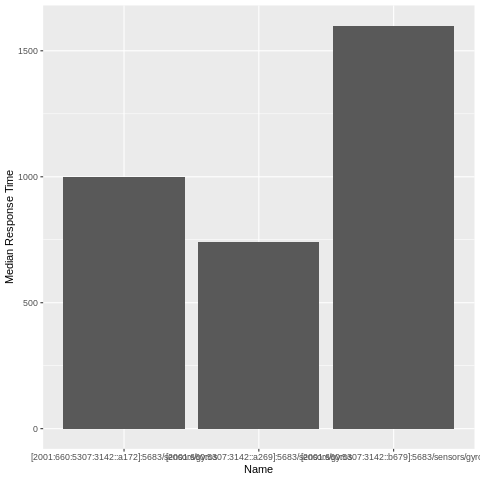

In [28]:
%%R -i df
library("ggplot2")
library("dplyr")
df %>% filter(Type == "coapclient") %>%
ggplot(aes(x=Name, y=`Median Response Time`)) + geom_col()

# Cleaning

In [29]:
en.run('pgrep -u "$(whoami)" tunslip6 | xargs -r kill', fit_frontend)


PLAY [all] *********************************************************************



TASK [pgrep -u "$(whoami)" tunslip6 | xargs -r kill] ***************************


 [started TASK: pgrep -u "$(whoami)" tunslip6 | xargs -r kill on grenoble]


changed: [grenoble]


CommandResult(host='grenoble', task='pgrep -u "$(whoami)" tunslip6 | xargs -r kill', status='OK', payload={'changed': True, 'stdout': '', 'stderr': '', 'rc': 0, 'cmd': 'pgrep -u "$(whoami)" tunslip6 | xargs -r kill', 'start': '2021-09-29 19:08:40.047978', 'end': '2021-09-29 19:08:40.068184', 'delta': '0:00:00.020206', 'msg': '', 'invocation': {'module_args': {'_raw_params': 'pgrep -u "$(whoami)" tunslip6 | xargs -r kill', '_uses_shell': True, 'warn': True, 'stdin_add_newline': True, 'strip_empty_ends': True, 'argv': None, 'chdir': None, 'executable': None, 'creates': None, 'removes': None, 'stdin': None}}, 'stdout_lines': [], 'stderr_lines': [], '_ansible_no_log': False})

In [30]:
if free_resources:
    g5k_provider.destroy()
    iotlab_provider.destroy()